# Differential Expression Development

Testing various functions for differential expression analysis.

## Imports

In [1]:
from IPython.core.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
repo_path = '/Users/mincheolkim/Github/'
data_path = '/Users/mincheolkim/Documents/'

In [3]:
import sys
sys.path.append(repo_path + 'scVI')
sys.path.append(repo_path + 'scVI-extensions')

In [4]:
import os

import numpy as np
from sklearn.manifold import TSNE
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import torch
import imp
from scipy.stats import ttest_ind, wasserstein_distance, ks_2samp
from scipy.stats import norm

from scvi.metrics.clustering import entropy_batch_mixing, get_latent
from scvi.models import VAE, SVAEC, VAEC
from scvi.inference import VariationalInference

In [5]:
import scvi_extensions.dataset.supervised_data_loader as sdl
import scvi_extensions.dataset.cropseq as cs
import scvi_extensions.inference.supervised_variational_inference as svi
import scvi_extensions.hypothesis_testing.mean as mn
import scvi_extensions.hypothesis_testing.utils as utils
import scvi_extensions.dataset.label_data_loader as ldl

## Create a dataset

In [6]:
h5_filename = '/Users/mincheolkim/Documents/raw_gene_bc_matrices_h5.h5'
abridged_metadata_filename = data_path + 'batf_nc_metadata.txt'

In [7]:
imp.reload(cs)
# Load the dataset
gene_dataset = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=abridged_metadata_filename,
    new_n_genes=1000,
    use_donors=True,
    use_labels='guide',
    save_path='')

Preprocessing CROP-seq dataset
Number of cells kept after filtering with metadata: 1400
Number of cells kept after removing all zero cells: 1400
Finished preprocessing CROP-seq dataset
Downsampling from 32738 to 1000 genes


In [8]:
imp.reload(cs)
# Load the dataset
gene_dataset_de = cs.CropseqDataset(
    filename=h5_filename,
    metadata_filename=abridged_metadata_filename,
    new_n_genes=1000,
    use_donors=True,
    use_labels='guide',
    testing_labels='guide',
    save_path='')

Preprocessing CROP-seq dataset
Number of cells kept after filtering with metadata: 1400
Number of cells kept after removing all zero cells: 1400
Finished preprocessing CROP-seq dataset
Downsampling from 32738 to 1000 genes


## Useful functions

In [11]:
def plot_pair_densities(vae, inference, n_points=1000, sigma=1.5):
    latent, batch_indices, labels = get_latent(vae, inference.data_loaders['sequential'])
    latent, idx_t_sne = inference.apply_t_sne(latent, n_points)
    batch_indices = batch_indices[idx_t_sne].ravel()
    labels = labels[idx_t_sne].ravel()
    
    plt.figure(figsize=(10, 20))
    for label, guide in enumerate(inference.gene_dataset.guide_lookup):
        guide_latent = latent[labels == label, :]
        guide_heatmap, guide_xedges, guide_yedges = np.histogram2d(guide_latent[:, 0], guide_latent[:, 1], bins=30)
        guide_heatmap = gaussian_filter(guide_heatmap, sigma=sigma)
        plt.subplot(1, len(inference.gene_dataset.guide_lookup)+1, label+1)
        plt.imshow(guide_heatmap.T, extent=None, origin='lower', cmap=matplotlib.cm.jet, aspect=1)
        plt.title(guide)
    plt.show()

## Supervised training

In [12]:
n_epochs=200
lr=1e-4
use_batches=True
use_cuda=False

In [13]:
vaec = VAEC(gene_dataset.nb_genes, n_labels=gene_dataset.n_labels, n_batch=gene_dataset.n_batches * use_batches)
supervised_infer = svi.SupervisedVariationalInference(
    vaec, 
    gene_dataset, 
    train_size=0.9, 
    use_cuda=use_cuda,
    verbose=False,
    frequency=1)
supervised_infer.train(n_epochs=n_epochs, lr=lr)

training: 100%|██████████| 200/200 [03:48<00:00,  1.14s/it]


In [24]:
torch.save(vaec, '/Users/mincheolkim/Documents/vaec_batf_nc.model')

In [9]:
vaec = torch.load('/Users/mincheolkim/Documents/vaec_batf_nc.model', lambda storage, loc: storage)

Text(0.5,0,'iter')

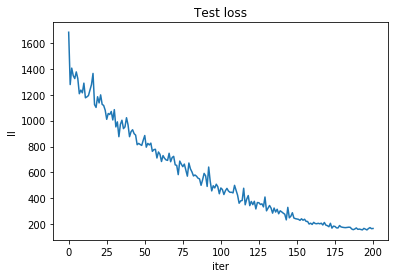

In [14]:
plt.plot(supervised_infer.history['ll_test'])
plt.title('Test loss')
plt.ylabel('ll')
plt.xlabel('iter')

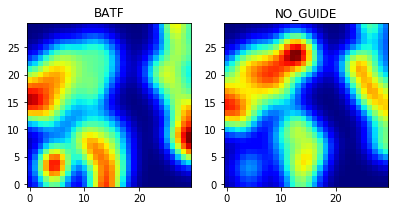

In [112]:
plot_pair_densities(vaec, supervised_infer, n_points=5000, sigma=2)

## Differential Expression

I test out some ways to perform differential expression.

First, I use scVI's method directly to compare any DE genes between BATF and control (there aren't any, in their definition)

### Default method for differential expression

In [19]:
imp.reload(mn)
null_rates, de_results = mn.differential_expression(vaec, gene_dataset_de, [0, 1], 100)

Sampling for differential expression...
Done sampling for differential expression...


In [21]:
gene_dataset_de.guide_lookup

array(['BATF', 'NO_GUIDE'], dtype=object)

In [29]:
de_results[0][1].head(5)

,gene,gene_index,P(H1),bayes_factor,bayes_factor_mag,pval,direction
348,STAT1,348,0.7991,1.380679,1.380679,0.0,1.0
430,NPC2,430,0.2519,-1.088504,1.088504,0.0,-1.0
888,LPXN,888,0.2551,-1.071594,1.071594,0.0,-1.0
27,RPL19,27,0.7241,0.964891,0.964891,0.0,1.0
410,SAP18,410,0.2879,-0.905605,0.905605,0.0,-1.0


In [30]:
de_results[0][1].tail(5)

,gene,gene_index,P(H1),bayes_factor,bayes_factor_mag,pval,direction
192,HIST1H1E,192,0.4996,-0.0016,0.0016,0.497525,-1.0
138,NPM1,138,0.5004,0.0016,0.0016,0.402843,1.0
121,CORO1A,121,0.4998,-0.0008,0.0008,0.473628,-1.0
108,HMGN2,108,0.4999,-0.0004,0.0004,0.461710,-1.0
336,LSM3,336,0.4999,-0.0004,0.0004,0.461710,-1.0


### Looking at distribution of Bayes factors for a gene and cell type

In [46]:
imp.reload(mn)
h1_bayes_factors, h0_bayes_factors = mn.batch_differential_expression(
    vaec, 
    gene_dataset_de, 
    M_sampling=100, 
    desired_labels=[0, 1])

/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/envs/scvi/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


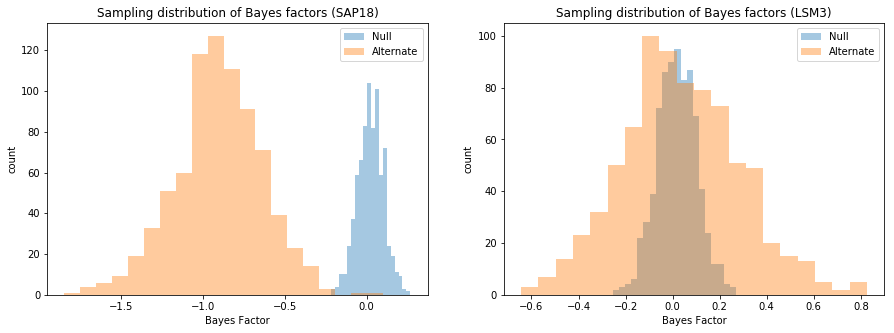

In [55]:
plt.figure(figsize=(15, 5));
plt.subplot(1, 2, 1);
sns.distplot(h0_bayes_factors[:, 410], kde=False, bins=20)
sns.distplot(h1_bayes_factors[:, 410], kde=False, bins=20)
plt.legend(['Null', 'Alternate']);
plt.title('Sampling distribution of Bayes factors (SAP18)');
plt.xlabel('Bayes Factor');plt.ylabel('count');
plt.subplot(1, 2, 2);
sns.distplot(h0_bayes_factors[:, 336], kde=False, bins=20)
sns.distplot(h1_bayes_factors[:, 336], kde=False, bins=20)
plt.legend(['Null', 'Alternate']);
plt.title('Sampling distribution of Bayes factors (LSM3)');
plt.xlabel('Bayes Factor');plt.ylabel('count');
plt.savefig('/Users/mincheolkim/Documents/scvi_outputs/labmeeting/de_bf_sampling_dist.png', bbox='tight')